In [1]:
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
import tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

#import matplotlib.pyplot as plt

In [2]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [3]:
model_ = torch.load('PHOCNet_all_case.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])

In [4]:
# find the file names
f = open('../splits/val_files.txt', 'rb')
A = f.readlines()
f.close()
A = [x.rstrip('\n') for x in A]

In [5]:
# load test images and words
images = np.load('../../../ProcessedData/original_images_nopad_'+A[0]+'.tiff.npy')
words = np.load('../../../ProcessedData/original_words_nopad_'+A[0]+'.tiff.npy')

In [6]:
images = np.transpose(images, (0,3,1,2))
images.shape

(544, 3, 135, 487)

In [7]:
# convert image tnto embedding using the cnn model
outputs = []
for i in range(len(images)):
    word_img = images[i]
    word_img = 1 - word_img.astype(np.float32) / 255.0
    word_img = word_img.reshape((1,) + word_img.shape)
    word_img = torch.from_numpy(word_img).float()
    word_img = word_img.cuda(gpu_id[0])
    word_img = torch.autograd.Variable(word_img)
    output = torch.sigmoid(cnn(word_img))
    output = output.data.cpu().numpy().flatten()
    outputs.append(output)

In [8]:
# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
def create_word_variations(words):
    word_var = {}
    root_word_var = {}
    for w in words:
        if len(w) < 2:
            continue
        root_var_list = [w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            word_var[var] = 0
            word_var[var[1:]] = 1
            word_var[var[:-1]] = -1
            var_set.add(var)
            var_set.add(var[1:])
            var_set.add(var[:-1])
        root_word_var[w] = var_set
    return word_var, root_word_var

In [9]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
word_strings = words
unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
bigram_levels = None
bigrams = None
phoc_unigram_levels=(1, 2, 4, 8)

word_var_dir, root_word_var = create_word_variations(word_strings)

embedding = build_phoc_descriptor(words=word_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)

word_var_strings = word_var_dir.keys()
embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)

# cross check that embedding and output dims match
print('embedding variations:', embedding_var.shape)
print('output dims', np.array(outputs).shape)

100%|██████████| 2527/2527 [00:00<00:00, 5288.01it/s]

('embedding variations:', (2527, 945))
('output dims', (544, 945))


In [10]:
# see sample keys from word_var
keys = word_var_dir.keys()
sample = random.sample(keys,10)
print 'randomly sampled key,value from word_var'
for sm in sample:
    print sm, word_var_dir[sm]

randomly sampled key,value from word_var
marion 0
HICKOR -1
lafayette 0
Bewaldet -1
pt 0
WRIGHT 0
swego 1
vienna 0
callaway 0
bewaesser -1


In [11]:
# see sample values from woor_word_var
keys = root_word_var.keys()
sample = random.sample(keys,10)
for sm in sample:
    print sm, root_word_var[sm]

CLARK set(['Clark', 'clark', 'CLARK', 'CLAR', 'LARK', 'Clar', 'lark', 'clar'])
CAMDEN set(['Camden', 'amden', 'AMDEN', 'CAMDE', 'camde', 'CAMDEN', 'camden', 'Camde'])
IND. set(['Ind', 'IND.', 'ND.', 'nd.', 'IND', 'Ind.', 'ind', 'ind.'])
HICKORY set(['hickory', 'HICKORY', 'Hickory', 'HICKOR', 'Hickor', 'hickor', 'ickory', 'ICKORY'])
Potosi set(['potosi', 'OTOSI', 'potos', 'Potosi', 'POTOSI', 'Potos', 'otosi', 'POTOS'])
KALB set(['kalb', 'Kalb', 'alb', 'ALB', 'KALB', 'KAL', 'Kal', 'kal'])
gesundes set(['ESUNDES', 'GESUNDE', 'gesundes', 'Gesundes', 'Gesunde', 'esundes', 'gesunde', 'GESUNDES'])
RAILWAY, set(['ailway,', 'Railway,', 'Railway', 'railway,', 'AILWAY,', 'railway', 'RAILWAY,', 'RAILWAY'])
LINCOLN set(['lincoln', 'LINCOL', 'LINCOLN', 'Lincol', 'incoln', 'lincol', 'Lincoln', 'INCOLN'])
Galnesville set(['GALNESVILLE', 'ALNESVILLE', 'Galnesvill', 'GALNESVILL', 'Galnesville', 'galnesvill', 'galnesville', 'alnesville'])


In [12]:
# the new report matches method that handles variations
from scipy.spatial.distance import cdist, pdist, squareform
def report_matches_with_variations(outputs, embedding_var, matching, word_strings, 
                                   word_var_strings, k, length):
    # length sorting stuff
    qualified_ids = [x for x in range(len(word_strings)) if len(word_strings[x]) > length]
    outputs = np.array(outputs)
    word_strings = np.array(word_strings)
    outputs = list(outputs[qualified_ids])
    word_strings = list(word_strings[qualified_ids])
    
    # same stuff for variations
    qualified_ids_vars = [x for x in range(len(word_var_strings)) if len(word_var_strings[x]) > (length-1)]
    embedding_var = np.array(embedding_var)
    word_var_strings = np.array(word_var_strings)
    embedding_var = list(embedding_var[qualified_ids_vars])
    word_var_strings = list(word_var_strings[qualified_ids_vars])
    
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding_var, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    # get all matched words
    for i in range(len(q)):
        matched = []
        #print q[i]
        for j in q[i]:
            matched.append(word_var_strings[j])
            img_dir.append(word_var_dir[word_var_strings[j]])
        matched_words.append(matched)
    
    # calculate accuracies
    for i in range(len(word_strings)):
        #print word_strings[i]
        if word_strings[i] in matched_words[i]:
            count = count+1
        else:
            for w in matched_words[i]:
                if w in root_word_var[word_strings[i]]:
                    count = count+1
                    break

    #q = np.squeeze(np.array(q))
    #p = np.arange(len(q))
    #print count
    return count, matched_words, outputs, qualified_ids, img_dir, word_strings

the accuracy is: 0.642666666667
************************************************************************
************************************************************************
Original image:


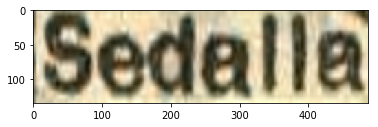

the matched words are (inorder): ['Sale']
the gound truth is:Sedalla
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


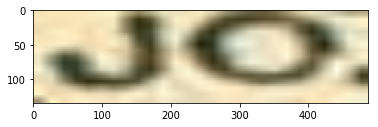

the matched words are (inorder): ['TEXA']
the gound truth is:JO.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


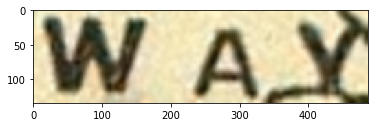

the matched words are (inorder): ['AN']
the gound truth is:WAY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


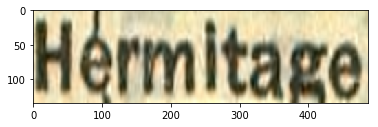

the matched words are (inorder): ['enorave']
the gound truth is:Hermitage
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


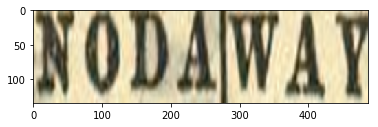

the matched words are (inorder): ['NODAWA']
the gound truth is:NODAWAY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


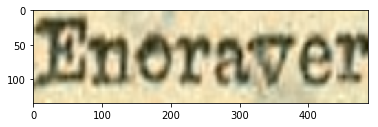

the matched words are (inorder): ['warre']
the gound truth is:Enoraver
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


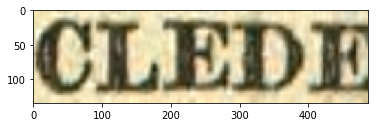

the matched words are (inorder): ['COOPE']
the gound truth is:CLEDE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


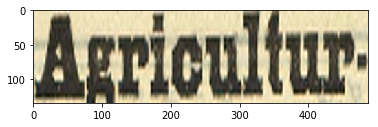

the matched words are (inorder): ['charita']
the gound truth is:Agricultur-
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


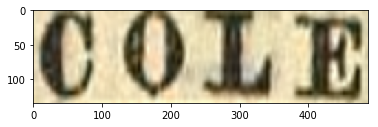

the matched words are (inorder): ['BOLL']
the gound truth is:COLE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


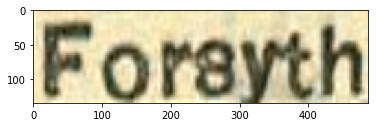

the matched words are (inorder): ['Fayett']
the gound truth is:Forsyth
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


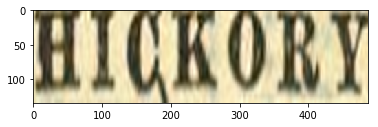

the matched words are (inorder): ['HICKOR']
the gound truth is:HICKORY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


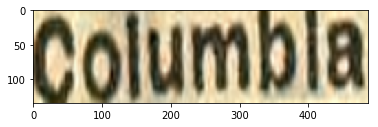

the matched words are (inorder): ['COL']
the gound truth is:Columbia
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


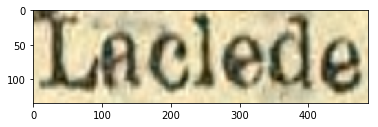

the matched words are (inorder): ['de']
the gound truth is:Laclede
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


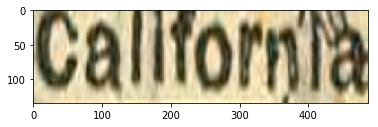

the matched words are (inorder): ['COOPE']
the gound truth is:California
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


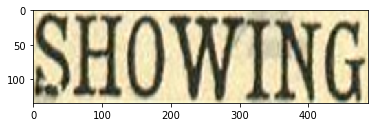

the matched words are (inorder): ['SHOWIN']
the gound truth is:SHOWING
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


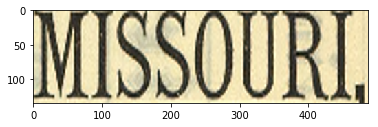

the matched words are (inorder): ['MISSOURI']
the gound truth is:MISSOURI,
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


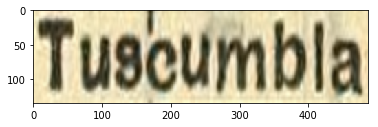

the matched words are (inorder): ['monitea']
the gound truth is:Tuscumbla
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


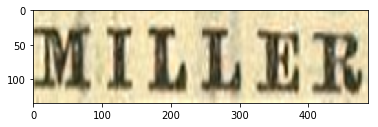

the matched words are (inorder): ['MILLE']
the gound truth is:MILLER
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


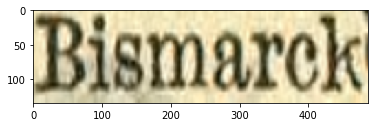

the matched words are (inorder): ['centrali']
the gound truth is:Bismarck
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


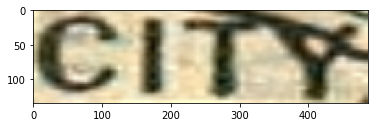

the matched words are (inorder): ['CY']
the gound truth is:CITY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


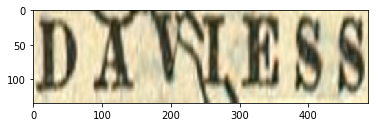

the matched words are (inorder): ['DAVIES']
the gound truth is:DAVIESS
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


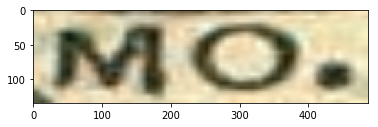

the matched words are (inorder): ['JO']
the gound truth is:MO.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


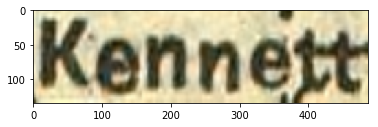

the matched words are (inorder): ['ne']
the gound truth is:Kennett
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


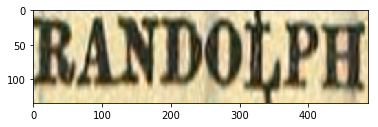

the matched words are (inorder): ['RANDOLP']
the gound truth is:RANDOLPH
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


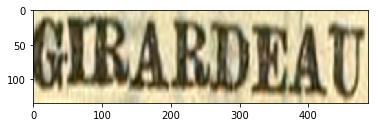

the matched words are (inorder): ['CHARITA']
the gound truth is:GIRARDEAU
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


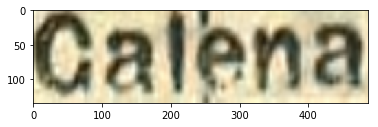

the matched words are (inorder): ['Calen']
the gound truth is:Calena
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


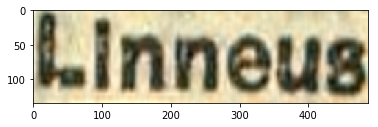

the matched words are (inorder): ['ne']
the gound truth is:Linneus
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


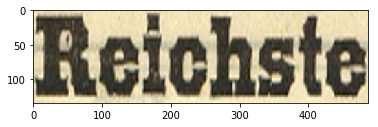

the matched words are (inorder): ['lancaste']
the gound truth is:Reicheste
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


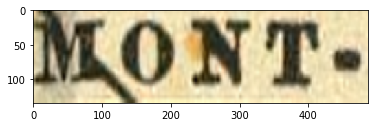

the matched words are (inorder): ['MONT']
the gound truth is:MONT-
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


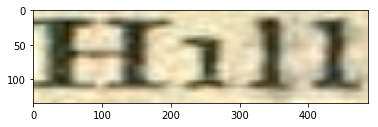

the matched words are (inorder): ['Rall']
the gound truth is:Hill
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


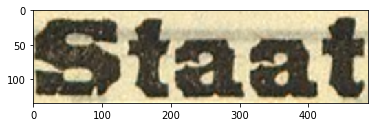

the matched words are (inorder): ['Sedall']
the gound truth is:Staat
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


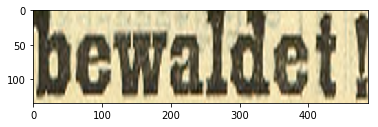

the matched words are (inorder): ['Bewaldet']
the gound truth is:bewaldet!
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


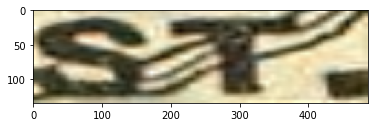

the matched words are (inorder): ['ST']
the gound truth is:ST.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


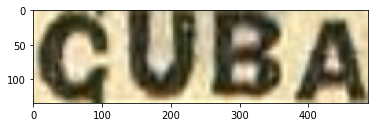

the matched words are (inorder): ['CLA']
the gound truth is:CUBA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


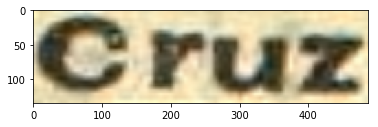

the matched words are (inorder): ['Cru']
the gound truth is:Cruz
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


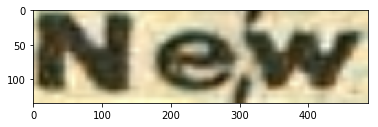

the matched words are (inorder): ['Wes']
the gound truth is:New
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


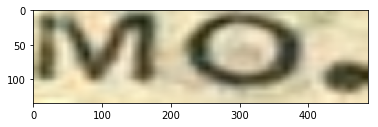

the matched words are (inorder): ['COL']
the gound truth is:MO.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


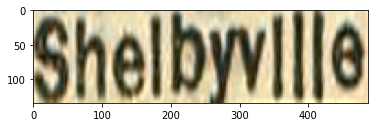

the matched words are (inorder): ['SULLIVA']
the gound truth is:Shelbyville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


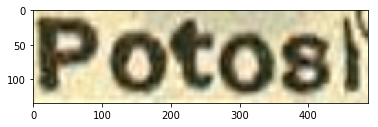

the matched words are (inorder): ['Potos']
the gound truth is:Potosi
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


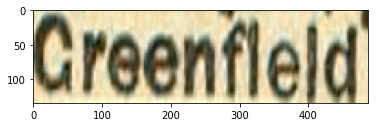

the matched words are (inorder): ['Collectio']
the gound truth is:Greenfield
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


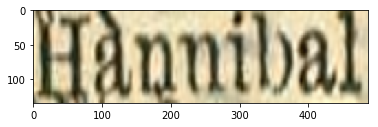

the matched words are (inorder): ['Hanniba']
the gound truth is:Hannibal
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


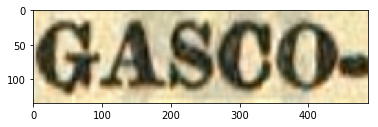

the matched words are (inorder): ['GASCO']
the gound truth is:GASCO-
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


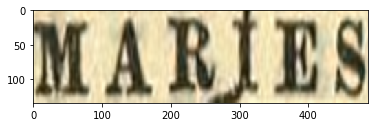

the matched words are (inorder): ['MARIE']
the gound truth is:MARIES
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


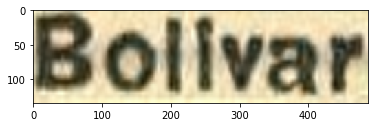

the matched words are (inorder): ['Boliva']
the gound truth is:Bolivar
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


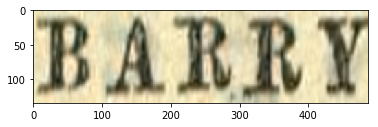

the matched words are (inorder): ['WARRE']
the gound truth is:BARRY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


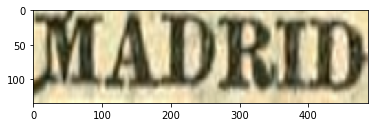

the matched words are (inorder): ['MARIO']
the gound truth is:MADRID
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


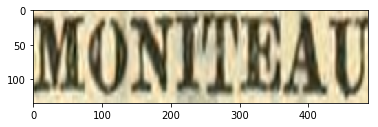

the matched words are (inorder): ['MONITEA']
the gound truth is:MONITEAU
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


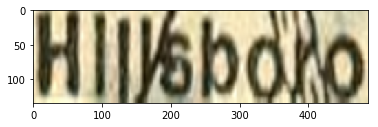

the matched words are (inorder): ['Washingto']
the gound truth is:Hillsboro
------------------------------------------------------------------------
------------------------------------------------------------------------


In [13]:
# image plot using the variations
import matplotlib.pyplot as plt

count, matched_words, new_outputs, qualified_ids, img_dirs, new_word_strings \
= report_matches_with_variations(outputs, embedding_var,'cosine', word_strings,word_var_strings,1, 2)

print "the accuracy is: "+str(count/float(len(new_word_strings)))

_len = min(500, len(matched_words))
new_images = images[qualified_ids]
for i in range(_len):
    if img_dirs[i] != -1:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(new_images[i],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(new_word_strings[i])
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"
pass

In [14]:
# the old original report matches method
from scipy.spatial.distance import cdist, pdist, squareform
def report_matches(outputs, embedding, matching, word_strings, k, length):
    # length sorting stuff
    qualified_ids = [x for x in range(len(word_strings)) if len(word_strings[x]) > length]
    outputs = np.array(outputs)
    embedding = np.array(embedding)
    word_strings = np.array(word_strings)
    outputs = list(outputs[qualified_ids])
    embedding = list(embedding[qualified_ids])
    word_strings = list(word_strings[qualified_ids])
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    # get all matched words
    #print len(outputs), len(embedding)
    for i in range(len(q)):
        matched = []
        #print q[i]
        for j in q[i]:
            matched.append(word_strings[j])
        matched_words.append(matched)
    
    #print len(word_strings), len(matched_words)
    for i in range(len(word_strings)):
        #print word_strings[i]
        if word_strings[i] in matched_words[i]:
            count = count+1

    #q = np.squeeze(np.array(q))
    #p = np.arange(len(q))
    #print count
    return count, matched_words, outputs, embedding, word_strings, qualified_ids

the accuracy is: 0.717333333333
************************************************************************
************************************************************************
Original image:


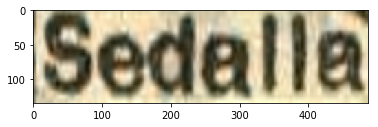

the matched words are (inorder): ['St.']
the gound truth is:Sedalla
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


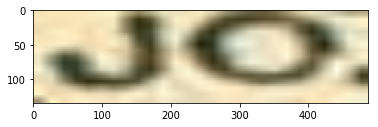

the matched words are (inorder): ['QUINCY']
the gound truth is:JO.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


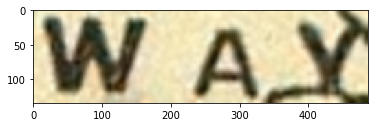

the matched words are (inorder): ['MARION']
the gound truth is:WAY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


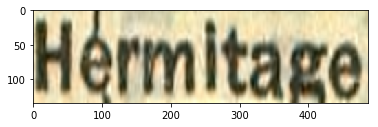

the matched words are (inorder): ['Hermitage']
the gound truth is:Hermitage
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


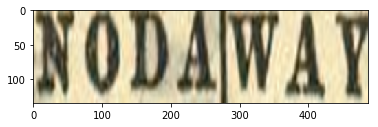

the matched words are (inorder): ['MONITEAU']
the gound truth is:NODAWAY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


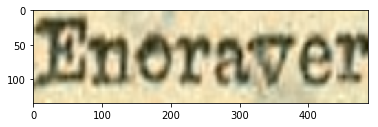

the matched words are (inorder): ['Prairie']
the gound truth is:Enoraver
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


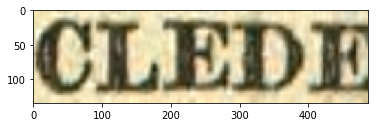

the matched words are (inorder): ['COLE']
the gound truth is:CLEDE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


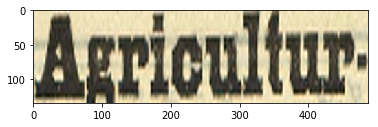

the matched words are (inorder): ['Associates,']
the gound truth is:Agricultur-
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


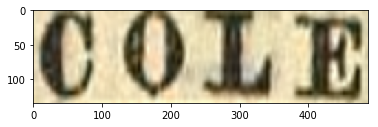

the matched words are (inorder): ['COLE']
the gound truth is:COLE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


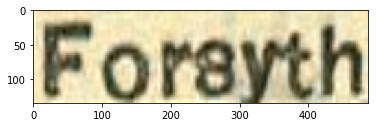

the matched words are (inorder): ['Forsyth']
the gound truth is:Forsyth
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


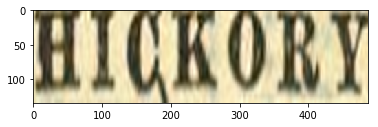

the matched words are (inorder): ['HICKORY']
the gound truth is:HICKORY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


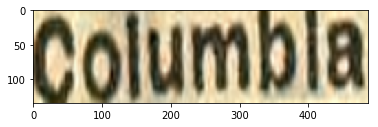

the matched words are (inorder): ['CARROLL']
the gound truth is:Columbia
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


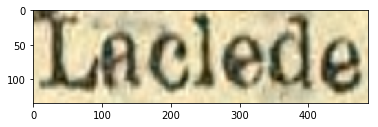

the matched words are (inorder): ['Laclede']
the gound truth is:Laclede
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


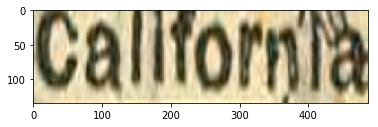

the matched words are (inorder): ['SCOTT']
the gound truth is:California
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


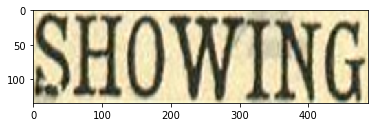

the matched words are (inorder): ['SHOWING']
the gound truth is:SHOWING
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


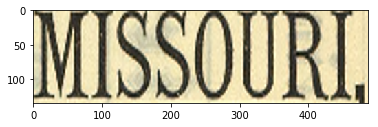

the matched words are (inorder): ['MISSOURI,']
the gound truth is:MISSOURI,
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


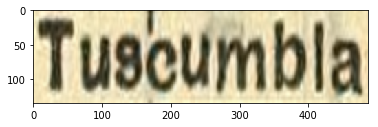

the matched words are (inorder): ['Tuscumbla']
the gound truth is:Tuscumbla
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


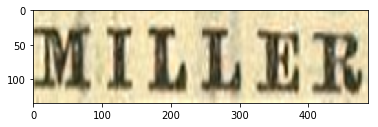

the matched words are (inorder): ['MILLER']
the gound truth is:MILLER
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


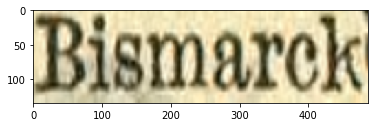

the matched words are (inorder): ['Bethany']
the gound truth is:Bismarck
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


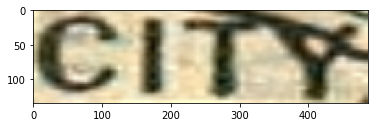

the matched words are (inorder): ['CITY']
the gound truth is:CITY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


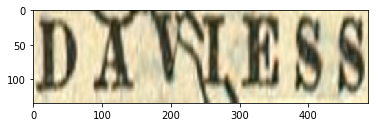

the matched words are (inorder): ['DAVIESS']
the gound truth is:DAVIESS
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


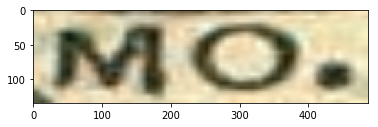

the matched words are (inorder): ['SCOTT']
the gound truth is:MO.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


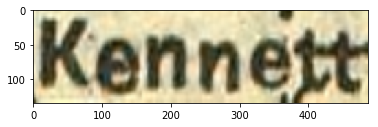

the matched words are (inorder): ['Kennett']
the gound truth is:Kennett
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


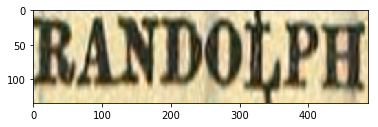

the matched words are (inorder): ['RANDOLPH']
the gound truth is:RANDOLPH
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


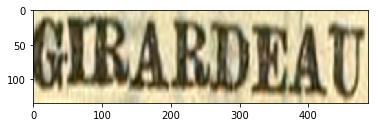

the matched words are (inorder): ['CHARITAN']
the gound truth is:GIRARDEAU
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


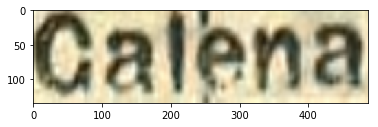

the matched words are (inorder): ['Calena']
the gound truth is:Calena
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


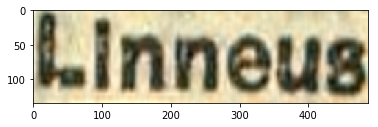

the matched words are (inorder): ['Linneus']
the gound truth is:Linneus
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


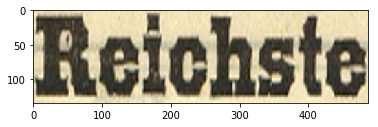

the matched words are (inorder): ['Reicheste']
the gound truth is:Reicheste
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


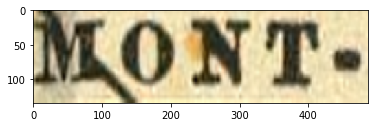

the matched words are (inorder): ['MONT-']
the gound truth is:MONT-
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


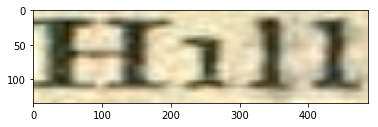

the matched words are (inorder): ['Hill']
the gound truth is:Hill
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


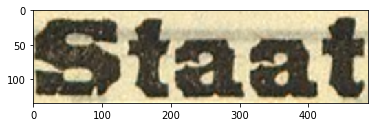

the matched words are (inorder): ['Sedalla']
the gound truth is:Staat
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


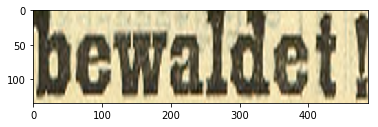

the matched words are (inorder): ['bewaldet!']
the gound truth is:bewaldet!
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


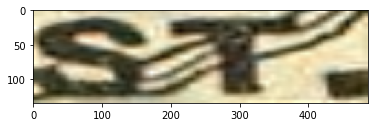

the matched words are (inorder): ['ST.']
the gound truth is:ST.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


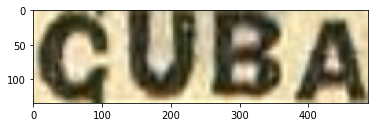

the matched words are (inorder): ['CUBA']
the gound truth is:CUBA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


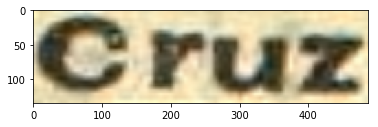

the matched words are (inorder): ['Cruz']
the gound truth is:Cruz
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


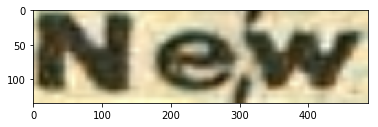

the matched words are (inorder): ['West']
the gound truth is:New
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


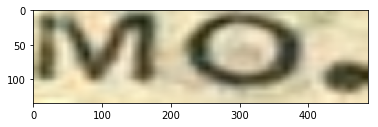

the matched words are (inorder): ['MO.']
the gound truth is:MO.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


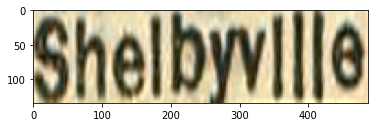

the matched words are (inorder): ['SULLIVAN']
the gound truth is:Shelbyville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


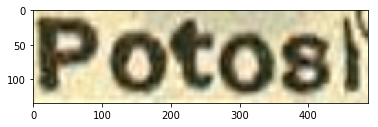

the matched words are (inorder): ['Potosi']
the gound truth is:Potosi
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


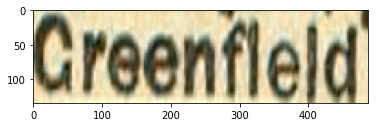

the matched words are (inorder): ['Coffeyville']
the gound truth is:Greenfield
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


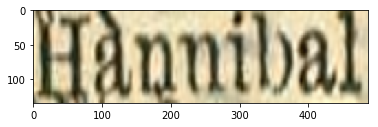

the matched words are (inorder): ['Hannibal']
the gound truth is:Hannibal
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


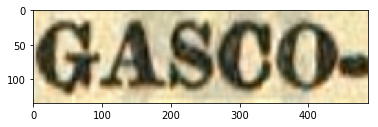

the matched words are (inorder): ['GASCO-']
the gound truth is:GASCO-
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


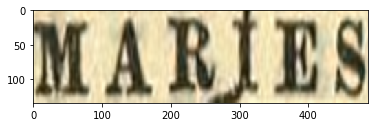

the matched words are (inorder): ['MARIES']
the gound truth is:MARIES
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


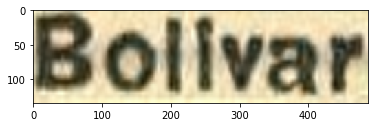

the matched words are (inorder): ['Bolivar']
the gound truth is:Bolivar
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


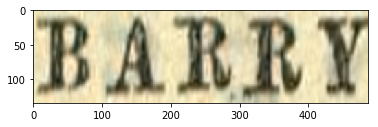

the matched words are (inorder): ['BARRY']
the gound truth is:BARRY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


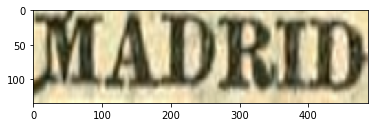

the matched words are (inorder): ['MADRID']
the gound truth is:MADRID
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


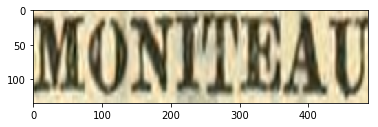

the matched words are (inorder): ['MONITEAU']
the gound truth is:MONITEAU
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


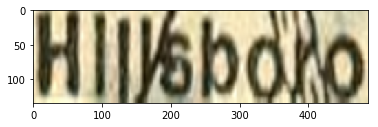

the matched words are (inorder): ['WASHINGTON']
the gound truth is:Hillsboro
------------------------------------------------------------------------
------------------------------------------------------------------------


In [15]:
# image plots using original without variation method for comparisons
import matplotlib.pyplot as plt

count, matched_words, new_outputs, new_embedding, new_word_strings, \
    qualified_ids = report_matches(outputs, embedding, 'cosine', word_strings, 1, 2)

print "the accuracy is: "+str(count/float(len(new_word_strings)))

_len = min(500, len(matched_words))
new_images = images[qualified_ids]
for i in range(_len):
    if img_dirs[i] != -1:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(new_images[i],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(new_word_strings[i])
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"
pass